In [1]:
#Name: Chaeyoon Kim
#City Email: Chaeyoon.Kim@city.ac.uk

***Data Science for COVID-19 (DS4C) in South Korea [Online]. Available at:  https://www.kaggle.com/kimjihoo/coronavirusdataset***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import folium 
from folium import plugins

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly import tools

In [3]:
patient = pd.read_csv('PatientInfo.csv')
#patient = pd.read_csv('edit_PatientInfo.csv')
route = pd.read_csv('PatientRoute.csv')
region = pd.read_csv('Region.csv')
timeage = pd.read_csv('TimeAge.csv')
timegender = pd.read_csv('TimeGender.csv')
policy = pd.read_csv('Policy.csv')
patient.head(3)

patient_id   sex  age country province         city        infection_case  \
0  1000000001  male  50s   Korea    Seoul   Gangseo-gu       overseas inflow   
1  1000000002  male  30s   Korea    Seoul  Jungnang-gu       overseas inflow   
2  1000000003  male  50s   Korea    Seoul    Jongno-gu  contact with patient   

  infected_by  contact_number symptom_onset_date confirmed_date released_date  \
0         NaN            75.0         2020-01-22     2020-01-23    2020-02-05   
1         NaN            31.0                NaN     2020-01-30    2020-03-02   
2  2002000001            17.0                NaN     2020-01-30    2020-02-19   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released

In [4]:
data = patient.copy()

In [5]:
data.isnull().sum()

patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4381
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

In [6]:
print('the number of province in South Korea:',len(data['province'].unique())) 
data['province'].unique()

the number of province in South Korea: 17


array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Gyeonggi-do', 'Sejong', 'Ulsan', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

In [7]:
regional_patient = pd.merge(patient[['patient_id','confirmed_date','sex','age','infection_case','contact_number','province','city']],region[['province','city','latitude','longitude']], how = 'left', on = ['province','city'])
display(regional_patient.head(3))

patient_id confirmed_date   sex  age        infection_case  contact_number  \
0  1000000001     2020-01-23  male  50s       overseas inflow            75.0   
1  1000000002     2020-01-30  male  30s       overseas inflow            31.0   
2  1000000003     2020-01-30  male  50s  contact with patient            17.0   

  province         city   latitude   longitude  
0    Seoul   Gangseo-gu  37.551166  126.849506  
1    Seoul  Jungnang-gu  37.606832  127.092656  
2    Seoul    Jongno-gu  37.572999  126.979189

In [8]:
regional_patient.sort_values('contact_number', ascending=False).head(10)

patient_id confirmed_date     sex  age        infection_case  \
1463  1200000031     2020-02-18  female  60s    Shincheonji Church   
1312  1100000001     2020-02-21    male  10s         Onchun Church   
1318  1100000007     2020-02-22    male  20s    Shincheonji Church   
1600  1300000001     2020-02-03  female  40s       overseas inflow   
2215  2000000003     2020-02-01    male  40s  contact with patient   
1323  1100000012     2020-02-22  female  50s    Shincheonji Church   
2218  2000000006     2020-02-05    male  30s       overseas inflow   
1439  1100000128     2020-04-18    male  50s                   etc   
3628  4100000090     2020-03-05    male  50s  contact with patient   
1350  1100000039     2020-02-24    male  20s  contact with patient   

      contact_number           province         city   latitude   longitude  
1463          1160.0              Daegu          NaN        NaN         NaN  
1312          1091.0              Busan   Dongnae-gu  35.205060  129.083673  
1318           485.0              Busan          NaN        NaN         NaN  
1600           450.0            Gwangju          NaN        NaN         NaN  
2215           422.0        Gyeonggi-do   Bucheon-si  37.503393  126.766049  
1323           296.0              Busan       Nam-gu  35.136789  129.084140  
2218           290.0        Gyeonggi-do      Guri-si  37.594267  127.129549  
1439           185.0              Busan       Buk-gu  35.197483  128.990224  
3628           174.0  Chungcheongnam-do   Cheonan-si  36.814980  127.113868  
1350           159.0              Busan  Haeundae-gu  35.163360  129.163594

In [9]:
#obtain lat and long by province
temp = regional_patient.groupby(["province"]) \
    .apply(lambda x: x.loc[:, ["latitude", "longitude"]].dropna().mean(skipna = True)) \
    .reset_index() \
    .rename(mapper = {"latitude" : "lat", "longitude": "long"}, axis = 1)

In [10]:
temp_merged = pd.merge(left = regional_patient, right = temp,  how = "left", on = ["province"])
temp_merged.latitude = temp_merged.apply(
    axis = 1
    ,func = lambda x: x.latitude if not pd.isna(x.latitude) else x.lat)
temp_merged.longitude = temp_merged.apply(
    axis = 1
    ,func = lambda x: x.longitude if not pd.isna(x.longitude) else x.long)


temp_merged.loc[temp_merged.province == "Gwangju", "latitude"] =\
    temp_merged.loc[temp_merged.province == "Gwangju", "latitude"].fillna(value = 35.1595)
temp_merged.loc[temp_merged.province == "Gwangju", "longitude"] =\
    temp_merged.loc[temp_merged.province == "Gwangju", "longitude"].fillna(value = 126.8526)

out = temp_merged.drop(["lat", "long"], axis = 1)

In [11]:
out.head(3)

patient_id confirmed_date   sex  age        infection_case  contact_number  \
0  1000000001     2020-01-23  male  50s       overseas inflow            75.0   
1  1000000002     2020-01-30  male  30s       overseas inflow            31.0   
2  1000000003     2020-01-30  male  50s  contact with patient            17.0   

  province         city   latitude   longitude  
0    Seoul   Gangseo-gu  37.551166  126.849506  
1    Seoul  Jungnang-gu  37.606832  127.092656  
2    Seoul    Jongno-gu  37.572999  126.979189

In [12]:
out.groupby(["province"]).apply(lambda x: x.loc[:, ["latitude", "longitude"]].mean())

latitude   longitude
province                                
Busan              35.172811  129.073186
Chungcheongbuk-do  36.803358  127.693473
Chungcheongnam-do  36.720404  127.034392
Daegu              35.855074  128.578899
Daejeon            36.349120  127.388273
Gangwon-do         37.678148  128.002654
Gwangju            35.159500  126.852600
Gyeonggi-do        37.418280  126.998089
Gyeongsangbuk-do   36.021626  128.708770
Gyeongsangnam-do   35.313036  128.462405
Incheon            37.482885  126.695951
Jeju-do            33.488936  126.500423
Jeollabuk-do       35.856518  127.011709
Jeollanam-do       34.873378  126.969195
Sejong             36.480132  127.289021
Seoul              37.543939  126.976822
Ulsan              35.547736  129.340923

In [13]:
out[['latitude','longitude']].isnull().sum() # check missing values

latitude     0
longitude    0
dtype: int64

In [14]:
regional_count = out[['latitude','longitude']]

m = folium.Map([36, 128], zoom_start=7, tiles='Stamen Terrain')
plugins.MousePosition().add_to(m) 
plugins.MarkerCluster(regional_count).add_to(m)
m

In [15]:
heat_data = out\
.groupby(['latitude','longitude'])['patient_id'].count().reset_index()\
.values\
.tolist()

m = folium.Map([36, 128], zoom_start=7, tiles = 'stamentoner')

folium.plugins.HeatMap(heat_data).add_to(m)

m

In [16]:
male_patient = out\
.query('sex in ("male")')[['latitude','longitude']].dropna()

female_patient = out\
.query('sex in ("female")')[['latitude','longitude']].dropna()


m = folium.Map([36, 128], zoom_start=7, tiles='Stamen Terrain') 
initial = folium.plugins.MarkerCluster(control=False)
m.add_child(initial)

female_g = plugins.FeatureGroupSubGroup(initial, 'Female')
m.add_child(female_g)

male_g = plugins.FeatureGroupSubGroup(initial, 'Male') 
m.add_child(male_g)

plugins.MarkerCluster(female_patient).add_to(female_g)
plugins.MarkerCluster(male_patient).add_to(male_g)

folium.LayerControl(collapsed=False).add_to(m)
m

In [17]:
timeage.head(3)

date  time  age  confirmed  deceased
0  2020-03-02     0   0s         32         0
1  2020-03-02     0  10s        169         0
2  2020-03-02     0  20s       1235         0

In [18]:
fig = px.bar(timeage, x='date', y='confirmed', 
             color = "age", color_discrete_sequence = px.colors.qualitative.Pastel)

fig.update_layout(title='<b>Cumulative graph of confirmed case regarding on age</b>', 
                  plot_bgcolor="#FFFFFF",yaxis_gridcolor = '#D5D5D5')

fig.show()

In [19]:
fig = px.bar(timeage, x='date', y='deceased', 
             color = "age", color_discrete_sequence = px.colors.qualitative.Pastel)

fig.update_layout(title='<b>Cumulative graph of deceased case regarding on age</b>', 
                  plot_bgcolor="#FFFFFF",yaxis_gridcolor = '#D5D5D5')

fig.show()

In [20]:
age_encoding = {"0s": 0, "10s": 10, "20s": 20, "30s": 30, "40s": 40, "50s": 50, "60s": 60, "70s": 70, "80s": 80, "90s": 90}
timeage.loc[:, "age"] = timeage.loc[:, "age"].map(lambda x: age_encoding[x])

array([[1.        , 0.76295324],
       [0.76295324, 1.        ]])

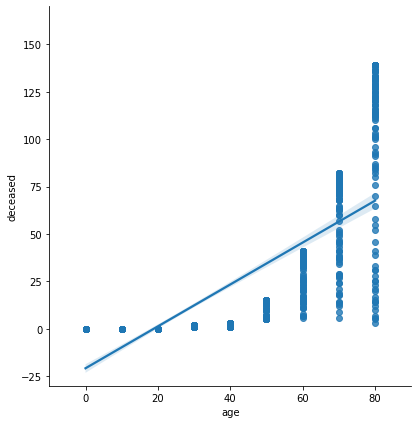

In [21]:
aplot = sns.lmplot(x='age', y='deceased', data=timeage, height=6)
aplot.set(xlim=(-10, 90))
aplot.set(ylim=(-30,170))
np.corrcoef(timeage['age'], timeage['deceased'])

array([[ 1.        , -0.03900228],
       [-0.03900228,  1.        ]])

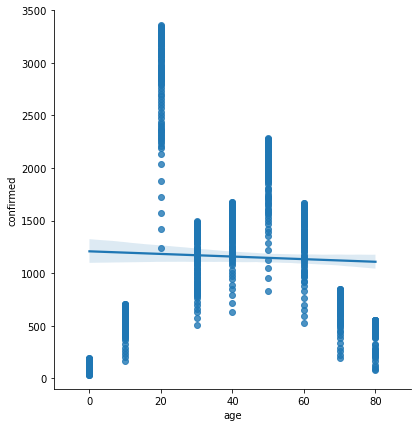

In [22]:
bplot = sns.lmplot(x='age', y='confirmed', data=timeage, height=6)
bplot.set(xlim=(-10, 90))
bplot.set(ylim=(-100,3500))
np.corrcoef(timeage['age'], timeage['confirmed'])

In [23]:
gender = temp_merged.drop(["patient_id", "infection_case", "contact_number", "city", "latitude", "longitude", "lat", "long"], axis = 1)
gender.head(3)

confirmed_date   sex  age province
0     2020-01-23  male  50s    Seoul
1     2020-01-30  male  30s    Seoul
2     2020-01-30  male  50s    Seoul

In [24]:
gender[['sex','age']].isnull().sum() 

sex    1122
age    1380
dtype: int64

In [25]:
gender.dropna(inplace=True)

In [26]:
fig = px.bar(gender, x='confirmed_date', y='age', 
             color = "province", color_discrete_sequence = px.colors.qualitative.Pastel,
             facet_col="sex",
             category_orders={"age": ["0s", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s", "100s"]},
             title = "hello")

fig.update_layout(title='<b>Cumulative graph of confirmed case regarding on gender</b>', 
                  plot_bgcolor="#FFFFFF",yaxis_gridcolor = '#D5D5D5')

fig.show()

In [27]:
fig = px.scatter(data_frame=gender, x='confirmed_date', y='age', color='province',
                 category_orders={"age": ["0s", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s", "100s"]},
                 title = "hello")
fig.show()

In [28]:
policy

policy_id country            type                              gov_policy  \
0           1   Korea           Alert          Infectious Disease Alert Level   
1           2   Korea           Alert          Infectious Disease Alert Level   
2           3   Korea           Alert          Infectious Disease Alert Level   
3           4   Korea           Alert          Infectious Disease Alert Level   
4           5   Korea     Immigration           Special Immigration Procedure   
..        ...     ...             ...                                     ...   
56         57   Korea  Transformation                        Logistics center   
57         58   Korea  Transformation                        Wearing of masks   
58         59   Korea  Transformation                        Wearing of masks   
59         60   Korea      Technology          KI-Pass: Korea Internet - Pass   
60         61   Korea          Health  Extends Tightened Quarantine Measures    

                                               detail  start_date    end_date  
0                                      Level 1 (Blue)  2020-01-03  2020-01-19  
1                                    Level 2 (Yellow)  2020-01-20  2020-01-27  
2                                    Level 3 (Orange)  2020-01-28  2020-02-22  
3                                       Level 4 (Red)  2020-02-23         NaN  
4                                          from China  2020-02-04         NaN  
..                                                ...         ...         ...  
56  On-site inspection of major logistics faciliti...  2020-05-29  2020-06-11  
57  Mandatory wearing of passenger mask domestic, ...  2020-05-27         NaN  
58  Drivers such as buses and taxis can refuse to ...  2020-05-26         NaN  
59  new quick response (QR) code system this week ...  2020-06-10         NaN  
60  Gov't Extends Tightened Quarantine Measures in...  2020-05-28  2020-06-14  

[61 rows x 7 columns]

In [29]:
timegender

date  time     sex  confirmed  deceased
0    2020-03-02     0    male       1591        13
1    2020-03-02     0  female       2621         9
2    2020-03-03     0    male       1810        16
3    2020-03-03     0  female       3002        12
4    2020-03-04     0    male       1996        20
..          ...   ...     ...        ...       ...
237  2020-06-28     0  female       7265       131
238  2020-06-29     0    male       5470       151
239  2020-06-29     0  female       7287       131
240  2020-06-30     0    male       5495       151
241  2020-06-30     0  female       7305       131

[242 rows x 5 columns]

<AxesSubplot:xlabel='confirmed', ylabel='deceased'>

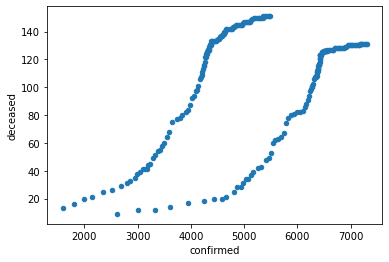

In [30]:
timegender.plot.scatter('confirmed','deceased')

# Merge two dataset

### load the first dataset (TCS)

In [31]:
import glob, os
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "edit_TCS_*.csv"))))
df.Date = pd.to_datetime(df['Date'], format='%Y%m%d')
df.head(3)

Date        Departure  Arrival_Capital  Arrival_Gangwon  \
0 2020-01-01          Capital           306460            40376   
1 2020-01-01          Gangwon            47022           139638   
2 2020-01-01  DaejeonChungnam            60883             2787   

   Arrival_DaejeonChungnam  Arrival_GwangjuJeonnam  Arrival_DaeguGyeongbuk  \
0                    58592                    2722                    7821   
1                     2618                     452                    2025   
2                    94303                    4432                    9472   

   Arrival_BusanGyeongnam  Arrival_Jeonbuk  Arrival_Chungbuk  Departure_SUM  \
0                    5351             6535             34426         462283   
1                     679              680             11916         205030   
2                    3856            24153             11630         211516   

   Arrival_SUM  
0       480418  
1       200723  
2       215565

In [32]:
df.drop(columns = ["Arrival_Capital", "Arrival_Gangwon", "Arrival_DaejeonChungnam", "Arrival_GwangjuJeonnam", "Arrival_DaeguGyeongbuk",
                  "Arrival_BusanGyeongnam", "Arrival_Jeonbuk", "Arrival_Chungbuk"], axis = 1, inplace = True)
df.head(3)

Date        Departure  Departure_SUM  Arrival_SUM
0 2020-01-01          Capital         462283       480418
1 2020-01-01          Gangwon         205030       200723
2 2020-01-01  DaejeonChungnam         211516       215565

### load the second dataset (confirmed cases by time and province)

In [33]:
timeprovince = pd.read_csv('edit_TimeProvince.csv')
timeprovince.head(3)

Date        province  confirmed  released  deceased  SUM_confirmed  \
0  1/20/2020  BusanGyeongnam          0         0         0            0.0   
1  1/20/2020  BusanGyeongnam          0         0         0            NaN   
2  1/20/2020  BusanGyeongnam          0         0         0            NaN   

   SUM_released  SUM_deceased  
0           0.0           0.0  
1           NaN           NaN  
2           NaN           NaN

In [34]:
timeprovince = pd.read_csv('edit_TimeProvince.csv')
timeprovince['Date'] = pd.to_datetime(timeprovince['Date'], format='%m/%d/%Y')
timeprovince = timeprovince[timeprovince['SUM_confirmed'].notna()]
timeprovince.drop(columns = ["confirmed", "released", "deceased"], axis = 1, inplace = True)
timeprovince = timeprovince.rename(columns={'province': 'Departure'})
timeprovince.head(3)

Date          Departure  SUM_confirmed  SUM_released  SUM_deceased
0 2020-01-20     BusanGyeongnam            0.0           0.0           0.0
3 2020-01-20            Capital            1.0           0.0           0.0
6 2020-01-20  Chungcheongbuk-do            0.0           0.0           0.0

In [35]:
newdata = pd.merge(\
    df[['Date','Departure','Departure_SUM','Arrival_SUM']]\
    ,timeprovince[['Date','Departure','SUM_confirmed']]\
    , how = 'left', on = ['Date','Departure'])
newdata.head(3)

Date        Departure  Departure_SUM  Arrival_SUM  SUM_confirmed
0 2020-01-01          Capital         462283       480418            NaN
1 2020-01-01          Gangwon         205030       200723            NaN
2 2020-01-01  DaejeonChungnam         211516       215565            NaN

In [36]:
newdata['SUM_TCS'] = newdata['Departure_SUM'].values + newdata['Arrival_SUM'].values
newdata.head(8)

Date        Departure  Departure_SUM  Arrival_SUM  SUM_confirmed  \
0 2020-01-01          Capital         462283       480418            NaN   
1 2020-01-01          Gangwon         205030       200723            NaN   
2 2020-01-01  DaejeonChungnam         211516       215565            NaN   
3 2020-01-01   GwangjuJeonnam         214430       214611            NaN   
4 2020-01-01   DaeguGyeongbuk         283644       273689            NaN   
5 2020-01-01   BusanGyeongnam         456228       456430            NaN   
6 2020-01-01          Jeonbuk         100039        95618            NaN   
7 2020-01-01         Chungbuk         109887       106003            NaN   

   SUM_TCS  
0   942701  
1   405753  
2   427081  
3   429041  
4   557333  
5   912658  
6   195657  
7   215890

In [45]:
remove_list = ['Gangwon','DaejeonChungnam', 'GwangjuJeonnam', 'BusanGyeongnam', 'Jeonbuk', 'Chungbuk']
newdata[~newdata['Departure'].isin(remove_list)]
newdata.dropna(inplace=True)
newdata.tail(3)

Date       Departure  Departure_SUM  Arrival_SUM  SUM_confirmed  \
1444 2020-06-30  DaeguGyeongbuk         277978       276749         8295.0   
1445 2020-06-30  BusanGyeongnam         470286       471758          343.0   
1446 2020-06-30         Jeonbuk          83145        82918           27.0   

      SUM_TCS  
1444   554727  
1445   942044  
1446   166063

In [46]:
capitalnew = newdata[newdata['Departure'].str.contains("Capital")]
DaeguGyeongbuknew = newdata[newdata['Departure'].str.contains("DaeguGyeongbuk")]

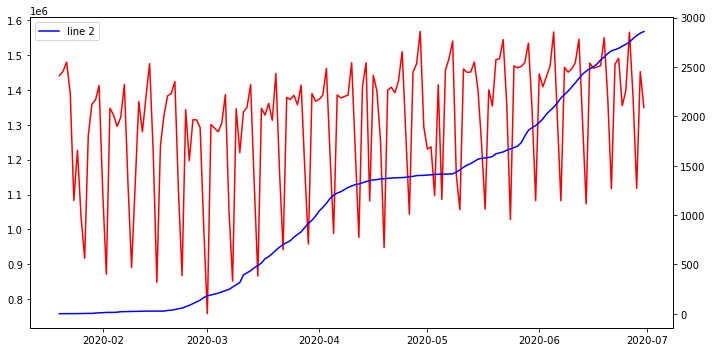

In [47]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(capitalnew['Date'], capitalnew['SUM_TCS'], label = "line 1", color = 'red')
ax2 = ax1.twinx()
ax2.plot(capitalnew['Date'], capitalnew['SUM_confirmed'], label = "line 2", color = 'blue')

fig.tight_layout()
plt.legend()
plt.show()

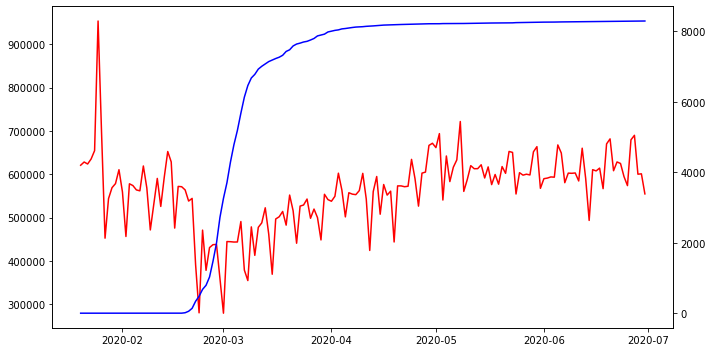

In [49]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(DaeguGyeongbuknew['Date'], DaeguGyeongbuknew['SUM_TCS'], label = "line 1", color = 'red')
ax2 = ax1.twinx()
ax2.plot(DaeguGyeongbuknew['Date'], DaeguGyeongbuknew['SUM_confirmed'], label = "line 2", color = 'blue')

fig.tight_layout()
plt.show()

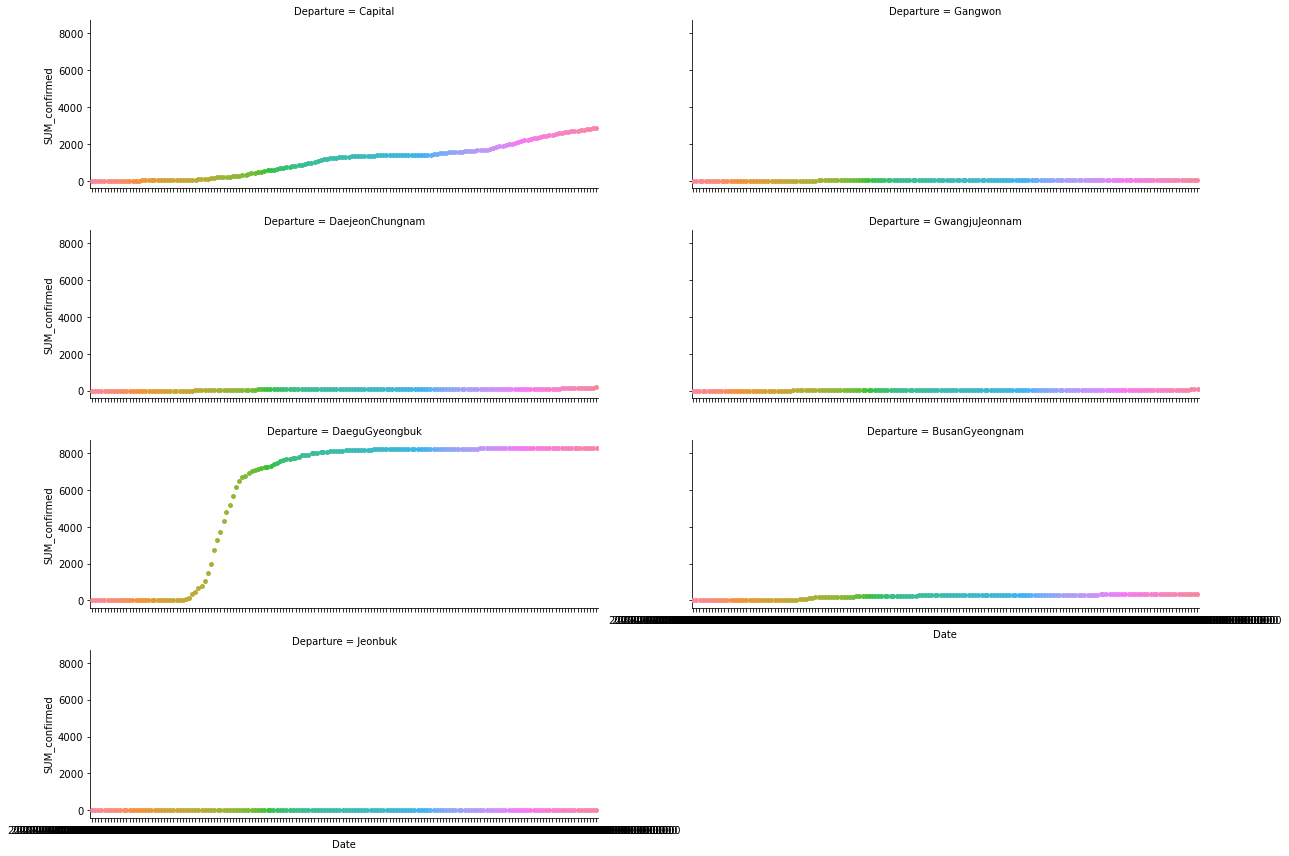

In [38]:
g = sns.catplot(x="Date", y="SUM_confirmed", col="Departure", col_wrap=2, data=newdata, height=3, aspect=3)